In [138]:
%matplotlib inline

# Loading Files

1. Import libaries
2. Load the data (This will most likely have to be done differently than here)
3. Evaulate raw instance of data, familarize yourself with the data

Opening raw data file /Users/jacobloranger/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>


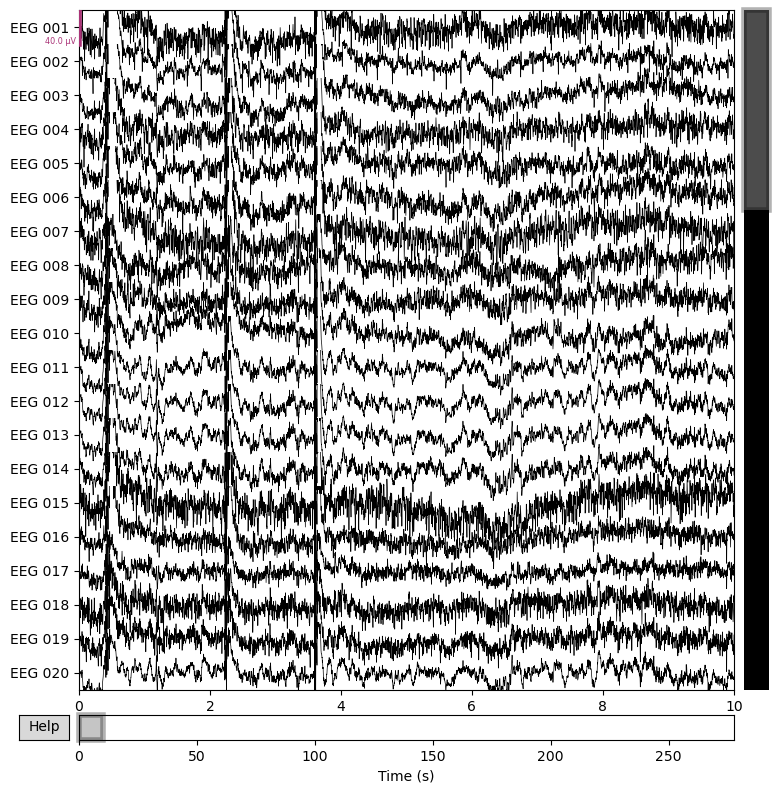

In [139]:
from mne.datasets import sample
import mne
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind

sample_data_folder = sample.data_path()
sample_data_raw_file = (sample_data_folder / 'MEG' / 'sample' /
                        'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file, preload=True)
raw.info

raw = raw.pick_types(eeg = True, meg = False, eog = False, stim=True, exclude = 'bads')
raw.plot();

# Preprocessing 

1. Determine best way to format the data (Raw, Epochs, Evoked, ICA, DataFrame)
2. Determine specific channels to evaluate and trim the rest
3. Determine filter range we want to evaluate

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 19821 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:    0.5s finished


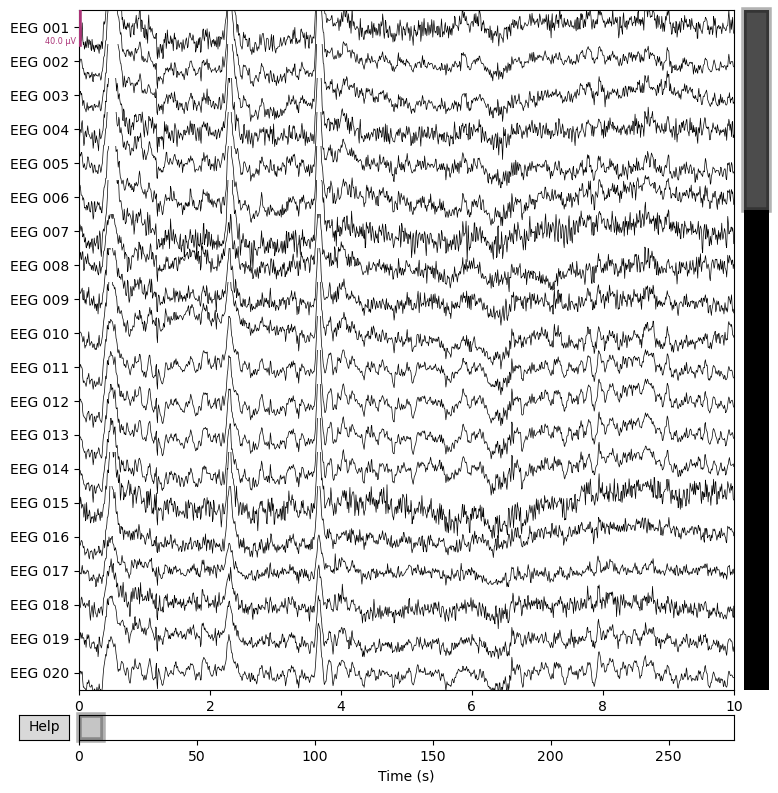

In [140]:
raw.filter(.1,40)
raw.plot();

# Analysis 

Goal: Determine the difference in brain activity between the frontal lobe and occipital lobe during visual and auditory stimuli


320 events found
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
320 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 320 events and 421 original time points ...
0 bad epochs dropped
Not setting metadata
145 matching events found
No baseline correction applied
0 projection items activated


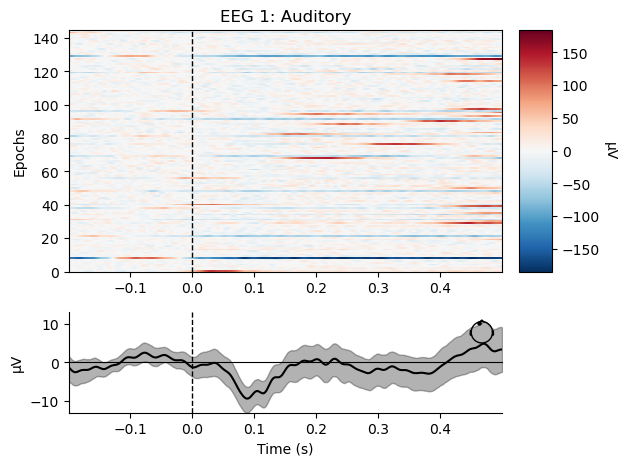

Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated


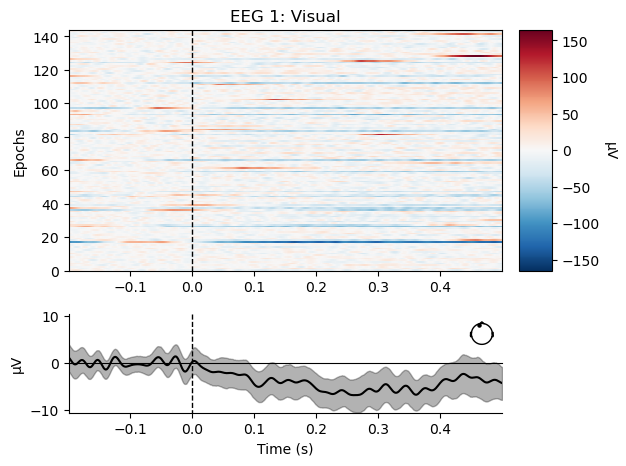

[<Figure size 640x480 with 4 Axes>]

In [141]:
# Create Epochs
events = mne.find_events(raw)
event_dict = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
              'visual/right': 4, 'smiley': 5, 'buttonpress': 32}
epochs = mne.Epochs(raw, events, event_id=event_dict, tmin = -0.2, tmax = 0.5, preload=True)

# Create Evokeds
aud_evoked = epochs["auditory"]
vis_evoked = epochs["visual"]


# Compare the signal of EEG #1 during an auditory v. visual stimuli
aud_evoked.plot_image(picks = ["EEG 001"], title = "EEG 1: Auditory")
vis_evoked.plot_image(picks = ["EEG 001"], title = "EEG 1: Visual")


It seems like the average auditory stimulus causes an increase in brain activity after about 0.2 seconds compared to the visual stimuli. Particularly in the left frontal lobe area where EEG 01 is located. This makes sense neurologically as the auditory processing section of the brain is located in the temporal lobe whereas, the visual processiong section of the brain is located in the occipital lobe. 

I'm curious as to the comparison of the signal when we examine an electrode located near the occiptal lobe. Will this information support the hypothesis stated above? 


Not setting metadata
145 matching events found
No baseline correction applied
0 projection items activated


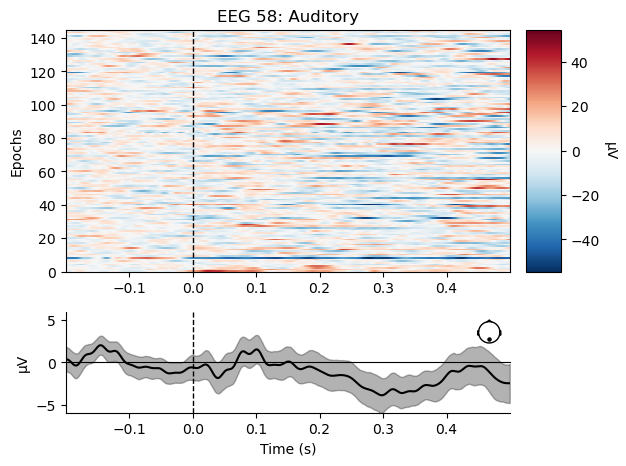

Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated


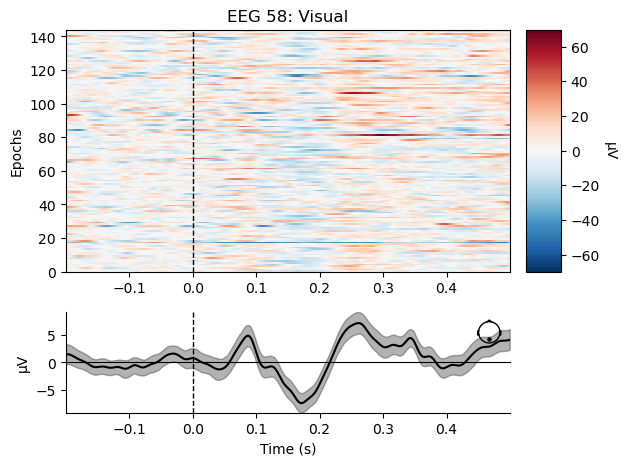

[<Figure size 640x480 with 4 Axes>]

In [142]:
# raw.plot_sensors(show_names = True) # Determine eeg sensor name of one near the occiptal lobe

aud_evoked.plot_image(picks = ["EEG 058"], title = "EEG 58: Auditory")
vis_evoked.plot_image(picks = ["EEG 058"], title = "EEG 58: Visual")

At first glance, this data seems to support the hypothesis that 1) the brain activity during an auditory stimuli will be greater near the frontal lobe compared to the occipital lobe, and 2) the brain activity during a visual stimuli will be greater near the occipital lobe compared to the frontal lobe. This finding also supports peer-reviewed literature stating that the auditory processing center is located near the frontal lobe and the visual processign center is located near the occipital lobe. 

To further test this hypothesis, a t-test will be performed between the EEG sensors for each condition to determine if this difference is statisitcally significant.

Null Hypothedsis: There is no difference in the signal between sensors
    - Accept when p-value > 0.05
    - Reject when p-value < 0.05

In [145]:
# Time interval that will be examined
tmin = 0.0
tmax = 0.4

aud_evoked.crop(tmin,tmax)
vis_evoked.crop(tmin,tmax)

aud_df = aud_evoked.to_data_frame(picks = ['EEG 001', 'EEG 058'])
vis_df = vis_evoked.to_data_frame(picks = ['EEG 001', 'EEG 058'])

aud_df.head()
vis_df.head()


t_test_aud = ttest_ind(aud_df["EEG 001"], aud_df["EEG 058"], nan_policy='omit')
t_test_vis = ttest_ind(vis_df["EEG 001"], vis_df["EEG 058"], nan_policy='omit')
print(t_test_aud)
print(t_test_vis)


Ttest_indResult(statistic=-6.300536173863027, pvalue=2.983777079951341e-10)
Ttest_indResult(statistic=-40.43925326132083, pvalue=0.0)


P-values are < 0.05 for both conditions, meaning we reject the null hypothesis. 

This gives statistical evidence that the signal between the two signals are different in both condiitons, meaning the brain activity between the frontal lobe and occiptal lobe are different in both conditions.


No projector specified for this dataset. Please consider the method self.add_proj.


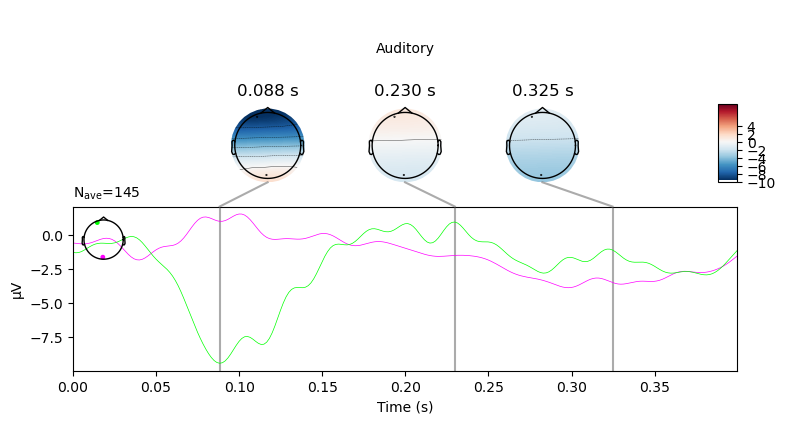

No projector specified for this dataset. Please consider the method self.add_proj.


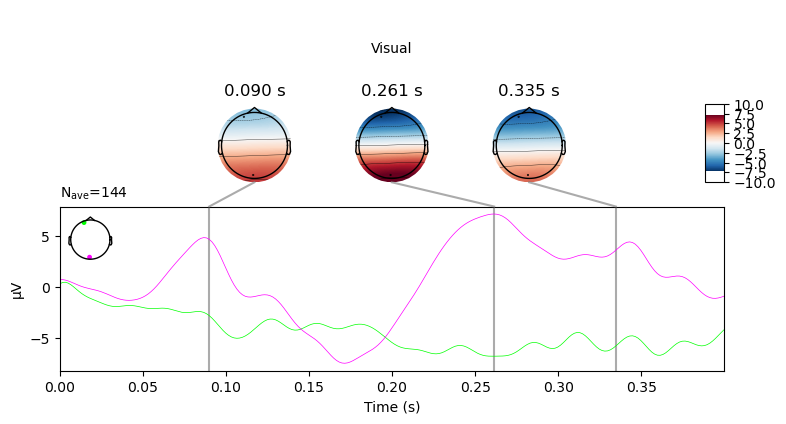

In [146]:
# Average the signals over all the epochs, then graph to compare

# Plot EEG 001 vs. EEG 058 for the auditory stimulis
aud_evoked.average().plot_joint(picks = ["EEG 001", "EEG 058"], title = "Auditory");

# Plot EEG 001 vs. EEG 058 for the visual stimulis
vis_evoked.average().plot_joint(picks = ["EEG 001", "EEG 058"], title = "Visual");

These visualizations give an insight as to the difference in brain activity of the occipital lobe vs the frontal lobe during visual and auditory stimuli. 

Auditory:

The occipital lobe is relevantly unactive during this stimuli, however the frontal lobe is active ~50 to ~150 ms after the stimulus is presented. This corelates with existing research as the average processing time for sound is 140–160 ms [1]

Visual: 

The frontal lobe activity after visual stimuli looks to be reletively unactive compared to the occipital lobe. The occipital lobe is actively working between initially between 50 - 200 ms. Then another burst of activity is present between about 220 - 370 ms. I'm thinking the first burst of activity is the processing of the visual stimuli (average processing time for visual stimuli is 180 - 200 ms [1]), and the second burst is the brain activity that initates eye movement. 


[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4456887/#:~:text=Auditory%20reaction%20time%20versus%20visual%20reaction%20time&text=A%20study%20was%20carried%20out,is%20around%20140%E2%80%93160%20ms. 